#**ECE 4554/ ECE 5554 / Computer Vision**
This file contains Machine Problems 1 and 2 for Homework 4. Your job is to implement/modify the sections within this notebook that are marked with "TO DO".

##**TO DO**: Enter your Virginia Tech Username (PID) here: 906525375 

##**Honor Code**

Please review the Honor Code statement in the syllabus.  This is not a "team project".  *Also, if you make use of code from ANY source except the instructor, you must provide comment lines in your programs to state where you obtained that code.* Failure to cite sources of code that you borrowed will be considered a violation of the Honor Code.

##**Code libraries**
You are allowed to use NumPy and Matplotlib functions to perform matrix operations and graphics/plotting operations. You are  allowed to use OpenCV functions for graphics/plotting, such as `cv2.circle` and `cv2.line`. You are also allowed to use any OpenCV functions that are provided in this start-up notebook, but do not use any other OpenCV functions without permission from the instructor.

##**Submission guidelines** for the coding problems (Google Colab)

1. Please verify that you have entered your Virginia Tech Username in all of the appropriate places.
2. After clicking Runtime->Run all, verify that all of your solutions are visible in this notebook.
3. Click File->Save near the top of the page to save the latest version of your notebook at Google Drive.
4. Verify that the last 2 cells have executed, creating a PDF version of this notebook at Google Drive. (Note: if you face difficulty with this step, please refer to https://pypi.org/project/notebook-as-pdf/)
5. Look at the PDF file and check that all of your solutions are displayed correctly there.
6. Download your notebook file and the PDF version to your laptop.
7. On your laptop, create a ZIP version of this notebook file. (Please don't include the separate data files.) Use file name Homework4_Code_USERNAME.zip, with your own Username.
6. For your PDF version, use file name Homework4_Notebook_USERNAME.pdf, with your own Username.
7. **Submit these 2 files and your PDF file for Problems 1-4 SEPARATELY to Canvas.** Do not zip them all together.

##**Overview**

For Machine Problem 1, you will write code to find the fundamental matrix for a stereo image pair. You will also write code to display keypoints and epipolar lines in the two images. For this problem, you may assume that no outliers are present in your set of corresponding image points.

In Machine Problem 2, you will extend the previous problem by using RANSAC to address the problem of outliers. 





# Environment setup

In [ ]:
# Mount your Google Drive to this notebook
# The purpose is to allow your code to access to your files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Change the directory to your own working directory
# Any files under your working directory are available to your code
# TO DO: enter the name of your directory
import os
os.chdir('/content/drive/MyDrive/5554/HW4')


In [ ]:
# Import library modules
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import optimize 
from PIL import Image  # Python Imaging Library
# The following is a substitute for cv2.imshow, 
#  which you would use on your local machine but Colab does not support it
from google.colab.patches import cv2_imshow

print('Python version:', sys.version)
print('OpenCV version:', cv2.__version__)
print('NumPy version: ', np.__version__)


Python version: 3.7.15 (default, Oct 12 2022, 19:14:55) 
[GCC 7.5.0]
OpenCV version: 4.6.0
NumPy version:  1.21.6


#Getting started

Several image files were provided to you (Durham*.png and others). Upload them to your working directory.

The following functions are helpful for loading images into floating-point format, and for displaying images that are in that format.  Let's use those functions to display a stereo image pair. 


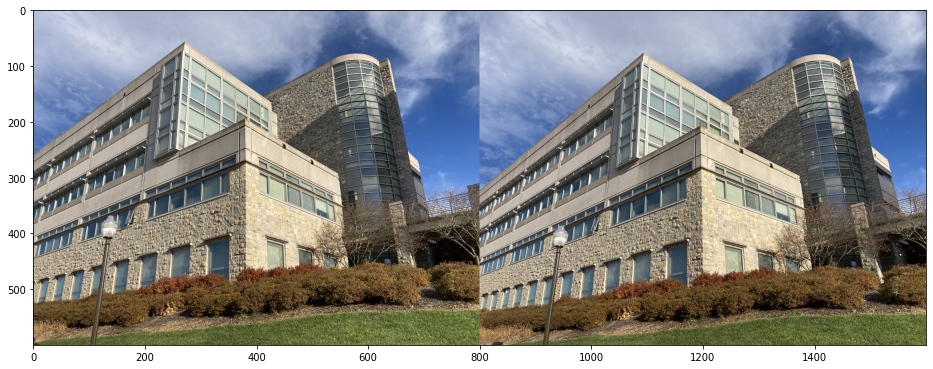

In [ ]:
def load_image(filename):
  img = np.asarray(Image.open(filename))
  img = img.astype("float32")/255.0
  return img

def show_image(img):
  fig = plt.figure()
  fig.set_size_inches(16, 10) # You can adjust the size of the displayed figure
  plt.imshow(img)

left_img = load_image("/content/Durham1.png")
right_img = load_image("/content/Durham2.png")
show_image(np.concatenate([left_img, right_img], axis=1))

Now verify that you can use OpenCV tools to detect SIFT-based keypoints. The following code block should detect keypoints in one of the Durham images, and then display the image using small small circles to indicate keypoint locations.

These library functions allow for many options. For example, if you change the `nfeatures` parameter for `SIFT_create`, you'll see different numbers of detected keypoints. You may want to experiment with these parameters later.

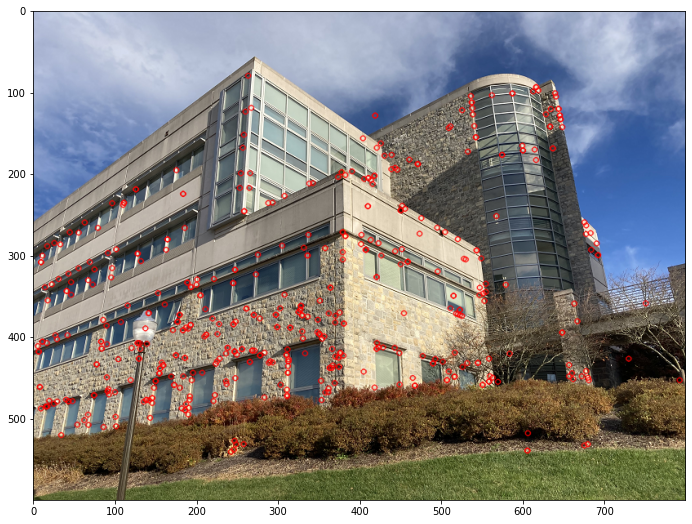

In [ ]:
def testSIFT(img1):
  sift = cv2.SIFT_create(nfeatures=500)
  kp = sift.detect(img1, None)
  img1=cv2.drawKeypoints(img1, kp, None, color=(0, 0, 255))
  
  fig = plt.figure()
  fig.set_size_inches(12, 9) # You can adjust the size of the displayed figure
  plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))


img = cv2.imread("/content/Durham1.png", cv2.IMREAD_COLOR)
testSIFT(img)

Next, verify that you can use a matching technique from OpenCV that tries to detect corresponding keypoints between 2 images. This example displays an example with a small number of correspondences.

The library call cv2.BFmatcher() is OpenCV's "brute force" matcher. More description is given in 
https://github.com/abidrahmank/OpenCV2-Python-Tutorials/blob/master/source/py_tutorials/py_feature2d/py_matcher/py_matcher.rst

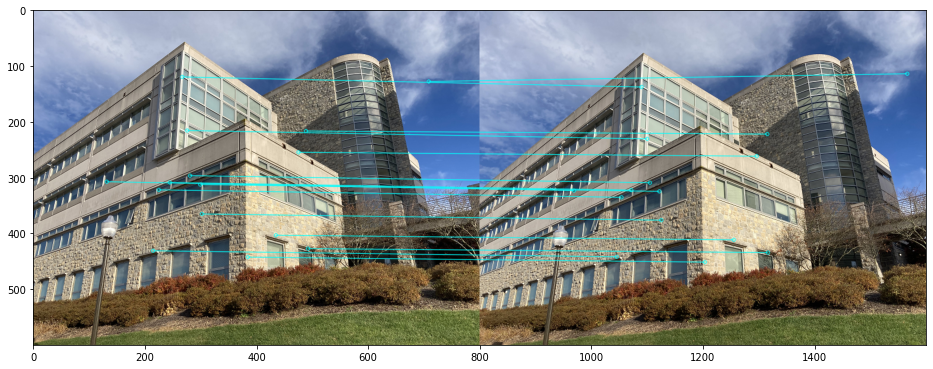

In [ ]:
def genSIFTMatchPairs(img1, img2, numberOfMatches):
  # Find keypoints and their SIFT descriptors in the two images
  sift = cv2.SIFT_create()
  kp1, des1 = sift.detectAndCompute(img1, None)
  kp2, des2 = sift.detectAndCompute(img2, None)

  # Search for corresponding pairs of points 
  bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
  matches = bf.match(des1, des2)

  # Sort them based on distance (dissimilarity) between two descriptors
  matches = sorted(matches, key = lambda x:x.distance)

  pts1 = np.zeros((numberOfMatches, 2))
  pts2 = np.zeros((numberOfMatches, 2))
  for i in range(numberOfMatches):
    pts1[i,:] = kp1[matches[i].queryIdx].pt
    pts2[i,:] = kp2[matches[i].trainIdx].pt
  return pts1, pts2, matches[:numberOfMatches], kp1, kp2

def testMatchingProcedure():
  img1 = cv2.imread('/content/Durham1.png')
  img2 = cv2.imread('/content/Durham2.png')
  
  # Perform the matching step (here, only the best 11 correspondences are returned)
  pts1, pts2, matches1to2, kp1, kp2 = genSIFTMatchPairs(img1, img2, 15)
  #print(pts1)
  #print(pts2)
  # Now pts1 and pts2 should contain lists of corresponding points 
  #  within img1 and img2, respectively
  #  Each point has the format [column row] 
  
  # Display the two images to check the results visually
  #  (the parameter flags=2 removes unmatched points from the display) 
  matching_result = cv2.drawMatches(img1, kp1, img2, kp2, matches1to2, None, flags=2,
    matchColor = (255, 255, 0), singlePointColor=(0, 0, 255))
  fig = plt.figure()
  fig.set_size_inches(16, 10) # You can adjust the size of the displayed figure
  plt.imshow(cv2.cvtColor(matching_result, cv2.COLOR_BGR2RGB))


testMatchingProcedure()

#Machine Problem 1: Fundamental matrix

The previous steps have shown how you can use OpenCV to find several pairs of corresponding points in two images. For this problem, you need to detect correspondences and use them to solve for the fundamental matrix *F* that relates the two images. You must demonstrate a correct result by using *F* to draw epipolar lines for keypoints that you detect.

The main parts of this problem are as follows:

*   **Part (a)** Write code that implements the **8-point algorithm to compute *F*.** For a given set of 8 or more correspondences, find a least-squares solution based on  those image points. An outline of the approach is given in the lecture slides: packet 17, page 23. 
*   **Part (b)** Write a function that uses *F* to **compute the epipoles** for the two images.
*   **Part (c)** Write a function to **display two images and highlight keypoints** that have been detected in both images. Also **display epipolar lines** that you obtain using your computed *F* matrix. One or both images should show epipolar lines passing through (or near) those keypoints. 
*   **Part (d)** Write a function that **combines all of the steps**, including keypoint detection and matching.

You do not need to consider outliers for this Machine Problem, and you do not need to consider additional steps that were described in the "Gold standard" algorithm from the lecture slides.

**Part 1(a).**
Implement the following function, as described above.



In [ ]:
##############################
# TO DO: Implement the findFundamentalMatrix function
#  (You are allowed to subdivide your code into additional functions that are called by this one)
#
def findFundamentalMatrix(pts1, pts2, scale):
  '''Use the eight-point algorithm to compute the fundamental matrix for the given points. 
   Input:
    pts1: keypoint locations for image 1, shape (N, 2), where N >= 8
    pts2: keypoint locations for image 2, with a corresponding point for every one in pts1 
    scale: use this scale factor to convert all coordinates to the range [0, 1]
           (see the additional notes that have been provided for this problem)
   Returns:
    F: the fundamental matrix, shape (3, 3)  
  '''
  # The following line is just a placeholder. Replace it with your code.
  one=pts1/scale
  two=pts2/scale
  F=np.zeros((one.shape[0],9))
  for i in range(one.shape[0]):
    F[i:]=[two[i,0]*one[i,0], two[i,0]*one[i,1],two[i,0], two[i,1]*one[i,0],two[i,1]*one[i,1], two[i,1], one[i,0], one[i,1],1]
  
  u,s,v=np.linalg.svd(F)
  F=v[-1].reshape(3,3)

  u,s,v=np.linalg.svd(F)
  s[2]=0

  F=np.dot(u,np.dot(np.diag(s),v))
  F=F/F[2][2]
  
  T= np.diag([1/scale,1/scale,1])
  F = np.dot(T.T, np.dot(F,  T))


  
  

 
  

  
  

  return F



**Part 1(b).** Write a function that uses *F* to compute the epipoles for the 
two images.

In [ ]:
##############################
# TO DO: Implement the findEpipoles function
#
def findEpipoles(F):
  '''Compute the two epipoles from a given fundamental matrix
   Input:
    F: fundamental (or essential) matrix, shape (3, 3)
   Returns:
    e1, e2: the two epipoles; each is a vector with 3 components
  '''
  # The following 2 lines are just placeholders. Replace them with your code.
  u1,s1,v1=np.linalg.svd(F)

  e1 = v1[-1]
  #print("tra",np.transpose(F))
  u2,s2,v2 = np.linalg.svd(np.transpose(F))
  #print(v2[-1])
  e2=v2[-1]



  return e1, e2
  

For grading purposes, run the following code block to print your computed matrix *F* and the two epipoles for the sample points that are given below.

In [ ]:
##############################
# Do not modify this code block 
#  (For debugging, you could copy this code to another block and edit it there)

# The following are some matching keypoints that were detected in the Durham1 and Durham2 images.
pts1_list = [
  [224.95256042, 321.64755249],
  [280.72879028, 296.15835571],
  [302.34194946, 364.82437134],
  [434.68283081, 402.86990356],
  [244.64321899, 308.50286865],
  [488.62979126, 216.26953125],
  [214.77470398, 430.75869751],
  [299.20846558, 312.07217407],
  [266.94125366, 119.36679077],
  [384.41549683, 442.05865479],
  [475.28448486, 254.28138733]]

pts2_list = [
  [253.88285828, 335.00772095],
  [304.884552,   308.89205933],
  [325.33914185, 375.91308594],
  [455.15515137, 411.18075562],
  [271.48794556, 322.07028198],
  [515.11816406, 221.74610901],
  [245.31390381, 441.54830933],
  [321.74771118, 324.31417847],
  [289.86627197, 137.46456909],
  [403.3711853,  451.08905029],
  [496.16610718, 261.36074829]]
 
pts1 = np.asarray(pts1_list)  
pts2 = np.asarray(pts2_list)

# Compute F and the epipoles
#  Scale factor 800 is the largest (row, column) size of the Durham images
F = findFundamentalMatrix(pts1, pts2, 800)
e1, e2 = findEpipoles(F)

# Print F and the epipoles
print('F =\n', F)
print('\n')
print('normalized epipole #1:', e1/e1[2])
print('normalized epipole #2:', e2/e2[2])  


F =
 [[ 3.28478065e-08  1.28493071e-05 -7.16233345e-03]
 [-1.00288539e-05  2.32887152e-07 -1.82014238e-02]
 [ 5.70706593e-03  1.65178538e-02  1.00000000e+00]]


normalized epipole #1: [-1.80185470e+03  5.62016328e+02  1.00000000e+00]
normalized epipole #2: [-1.29574249e+03  5.64820637e+02  1.00000000e+00]


**Part 1(c).** 
Write a function `displayEpipolarLines` that will display two stereo images and highlight keypoints in both images. Also display epipolar lines in at least one of the images. This function should display information for all of the keypoints that are provided to it. For practical reasons, usually it is best to display a small number of keypoints (e.g., 15 or 20, not 200) so that it is relatively easy to see the individual keypoints and lines. 



In [ ]:
##############################
# TO DO: Implement the displayEpipolarLines function
#
def displayEpipolarLines(pts1, pts2, F, img1, img2):
  '''Display two images with highlighted keypoints and epipolar lines. 
     Assume that the keypoints have already been detected, and F has already been computed.
   Input:
    pts1: keypoint locations for image 1, shape (N, 2), where N >= 1
    pts2: keypoint locations for image 2, with a corresponding point for every one in pts1
    F:  fundamental matrix for the two images 
    img1: image 1
    img2: image 2
   Output:
    No return value; the output is a visual display  
  '''
  # write your code here
  image=img2
  image1=img1
  height, width = img2.shape[:2]
  color = (0,0,0)
  thickness = 4
  #image = cv2.circle(img2, pts2[0], radius=0, color=(0, 0, 255), thickness=-1)
  for i in range(len(pts1)):
    h=pts1[i]
    h=np.append(h,1)
    pro=np.matmul(F,np.transpose(h))
    vr=-(pro[2]/pro[1])
    ur=-(pro[2]/pro[0])
    if(ur<0):
      ur=-width*pro[0]
      ur=ur-pro[2]
      ur=ur/pro[1]
      en=(width,int(ur))
    else:
      en=(int(ur),0)

    if(vr<0):
      vr=-height*pro[1]
      vr=vr-pro[2]
      vr=vr/pro[0]
      st=(int(vr),height)
    else:
      st=(0,int(vr))



    
    
    #print('start',st)
    #print('en',en)
    cent=(int(pts2[i][0]),int(pts2[i][1]))
    cent1=(int(pts1[i][0]),int(pts1[i][1]))
    #print(cent)
    image = cv2.line(image, st, en, color, thickness)
    image = cv2.circle(image, cent, 2, (255,0,0), 9)
    image1=cv2.circle(image1,cent1, 2, (255,0,0), 9)

  
  #cv2_imshow(image)
  #cv2_imshow(image1)
  fig = plt.figure()
  fig.set_size_inches(16, 10)
  conc=np.concatenate([image1, image], axis=1)
  
  
  
  #plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  
  #plt.scatter(pts2[:, 0], pts2[:, 1], marker="o", color="red", s=200)
  plt.imshow(cv2.cvtColor(conc, cv2.COLOR_BGR2RGB))
  


Run the following code block to test your code. This test uses the precomputed set of 11 correspondences from the Durham images. (Here I'm using 11 correspondences because my least-squared results were much worse with a smaller number. Possible reasons: not well distributed spatially across the images, or lens distortion, etc.) 

Fmat =
 [[ 3.28478065e-08  1.28493071e-05 -7.16233345e-03]
 [-1.00288539e-05  2.32887152e-07 -1.82014238e-02]
 [ 5.70706593e-03  1.65178538e-02  1.00000000e+00]]


normalized epipole #1: [-1.80185470e+03  5.62016328e+02  1.00000000e+00]
normalized epipole #2: [-1.29574249e+03  5.64820637e+02  1.00000000e+00]


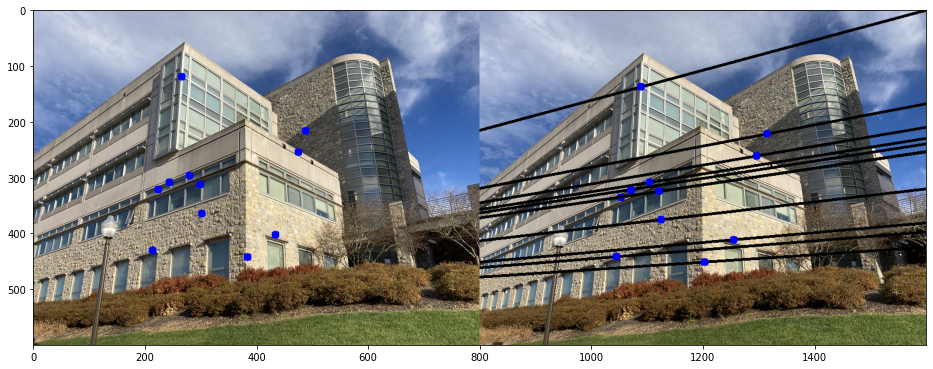

In [ ]:
##############################
# Do not modify this code block 
#  (For debugging, you could copy this code to another block and edit it there)
#
def testEpipolarLines():
  img1 = cv2.imread('/content/Durham1.png')
  img2 = cv2.imread('/content/Durham2.png')
  
  # The following are some matching keypoints that were detected in the Durham1 and Durham2 images.
  pts1_list = [
    [224.95256042, 321.64755249],
    [280.72879028, 296.15835571],
    [302.34194946, 364.82437134],
    [434.68283081, 402.86990356],
    [244.64321899, 308.50286865],
    [488.62979126, 216.26953125],
    [214.77470398, 430.75869751],
    [299.20846558, 312.07217407],
    [266.94125366, 119.36679077],
    [384.41549683, 442.05865479],
    [475.28448486, 254.28138733]]

  pts2_list = [
    [253.88285828, 335.00772095],
    [304.884552,   308.89205933],
    [325.33914185, 375.91308594],
    [455.15515137, 411.18075562],
    [271.48794556, 322.07028198],
    [515.11816406, 221.74610901],
    [245.31390381, 441.54830933],
    [321.74771118, 324.31417847],
    [289.86627197, 137.46456909],
    [403.3711853,  451.08905029],
    [496.16610718, 261.36074829]]

  pts1 = np.asarray(pts1_list)  
  pts2 = np.asarray(pts2_list)

  # Compute F and the epipoles
  #  Scale factor 800 is the largest (row, column) size of the Durham images
  Fmat = findFundamentalMatrix(pts1, pts2, 800)
  e1tmp, e2tmp = findEpipoles(Fmat)

  # Print F and the epipoles
  print('Fmat =\n', Fmat)
  print('\n')
  print('normalized epipole #1:', e1tmp/e1tmp[2])
  print('normalized epipole #2:', e2tmp/e2tmp[2]) 
  
  # Display the two images with epipolar lines highlighted
  displayEpipolarLines(pts1, pts2, Fmat, img1, img2)


testEpipolarLines()


**Part 1(d).**
Write a function that performs the full sequence of operations: load two images, detect SIFT keypoints, perform stereo matching, compute the fundamental matrix, and display the results.

Show your results using the files `operahouse1.png` and `operahouse2.png`.
For all steps up to performing stereo matching, you may borrow liberally from the "starter code" in this notebook, although you may need to adjust some of the parameters in order to get good results. To compute the fundamental matrix, you must call your function `findFundamentalMatrix`. To display the results, you must call your function `displayEpipolarLines`.


In [ ]:
##############################
# TO DO: Implement the following function 
#
def stereoMatchingAndDisplay(img1file, img2file):
  '''Extract keypoints from a stereo image pair, find corresponding points, 
      compute the fundamental matrix (assuming no outliers), 
      and display the results with sample epipolar lines. 
   Input:
    img1file: name of file containing image 1
    img2file: name of file containing image 2
   Output:
    No return value; the output is a visual display  
  '''
  img1 = cv2.imread('/content/opera1.png')
  img2 = cv2.imread('/content/opera2.png')
  pts1, pts2, matches1to2, kp1, kp2 = genSIFTMatchPairs(img1, img2, 15)
  #print(pts1)
  #print(pts2)
  Fmat = findFundamentalMatrix(pts1, pts2, 800)
  e1tmp, e2tmp = findEpipoles(Fmat)

  # Print F and the epipoles
  print('Fmat =\n', Fmat)
  print('\n')
  print('normalized epipole #1:', e1tmp/e1tmp[2])
  print('normalized epipole #2:', e2tmp/e2tmp[2])
  displayEpipolarLines(pts1, pts2, Fmat, img1, img2)
  matching_result = cv2.drawMatches(img1, kp1, img2, kp2, matches1to2, None, flags=2,
    matchColor = (255, 255, 0), singlePointColor=(0, 0, 255))
  fig = plt.figure()
  fig.set_size_inches(16, 10) # You can adjust the size of the displayed figure
  plt.imshow(cv2.cvtColor(matching_result, cv2.COLOR_BGR2RGB))






Run the following code block to test your  `stereoMatchingAndDisplay` function.

Fmat =
 [[-3.62765961e-06 -1.39176230e-04  4.59415919e-02]
 [ 1.41609735e-04 -8.37653384e-06 -6.33523840e-02]
 [-4.32238722e-02  6.02308247e-02  1.00000000e+00]]


normalized epipole #1: [466.18027124 317.94544659   1.        ]
normalized epipole #2: [413.75779346 315.83170861   1.        ]


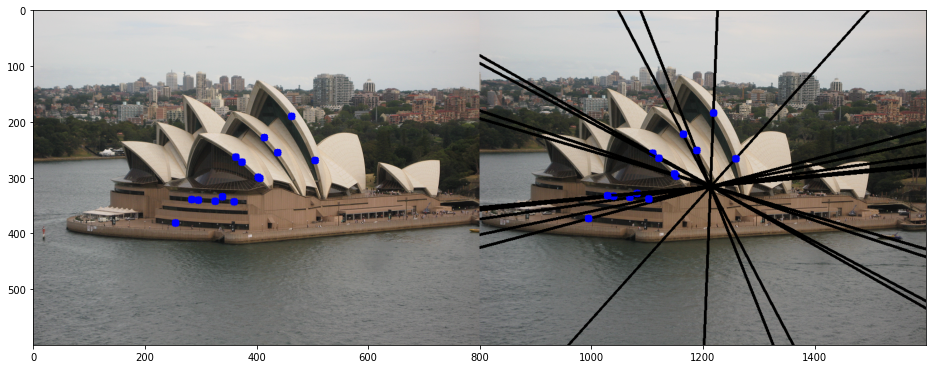

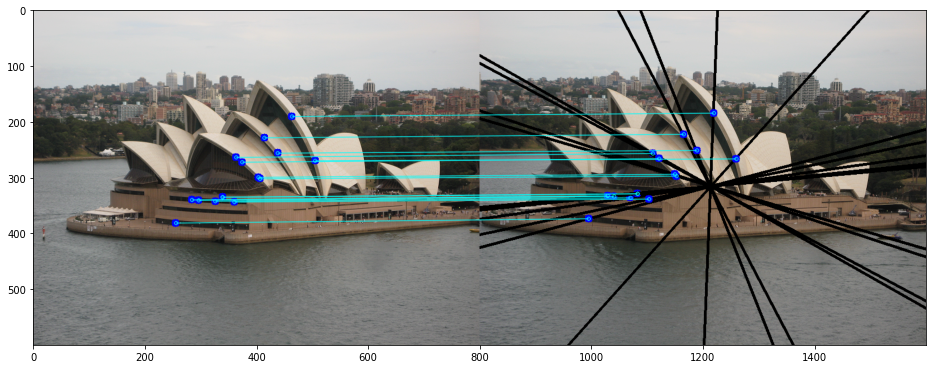

In [ ]:
stereoMatchingAndDisplay('/content/opera1.png', '/content/opera1.png') 

# Machine Problem 2: Using RANSAC to deal with outliers

In the previous problem, undoubtedly you saw that incorrect correspondences can be reported by the OpenCV tools. It is very likely that those false matches will act as outliers in your estimation of the fundamental matrix. 

As discussed during lectures, the RANSAC algorithm is a popular way to deal with outliers during model fitting. Here you must implement the RANSAC approach to compute the fundamental matrix *F*. 

A suggestion is that you detect *N*>20 correspondences from an image pair, and repeatly call your `findFundamentalMatrix` function with only 8 correspondences that are drawn at random. Based on the computed *F*, determine which correspondences are inliers, and refine your estimate of *F* using all of the inliers.

*Note that this problem is more open-ended than Machine Problem 1.* You need to make choices about what parameters to use, what input images to process, and what results to report. Use comments and print statements (as described below) to tell the grader what you have done. Try to make your explanations very clear to the grader.


In [ ]:
def distance(pts1,pts2,F):
  pts11=np.vstack([pts1[:,0],pts1[:,1],np.ones(pts1.shape[0])]).T
  pts22=np.vstack([pts2[:,0],pts2[:,1],np.ones(pts2.shape[0])]).T
  line1=pts11.dot(F.T)
  
  dist1=np.square(np.divide(np.sum(np.multiply(line1,pts22),axis=1),np.linalg.norm(line1[:,:2],axis=1)))
  
  total=(dist1).flatten()
  return total

In [ ]:
##############################
# TO DO: Implement the following function
#  (You are allowed to subdivide your code into additional functions that are called by this one)
#
def findFundamentalMatrixUsingRansac(pts1, pts2, scale):
  '''Use the eight-point algorithm  to compute the fundamental matrix for the given points,
     using RANSAC to deal with outliers. 
   Input:
    pts1: keypoint locations for image 1, shape (N, 2), where N >= 8
    pts2: keypoint locations for image 2, with a corresponding point for every one in pts1 
    scale: use this scale factor to convert all coordinates to the range [0, 1]
   Returns:
    F: the fundamental matrix, shape (3, 3)  
  '''
  # The following line is just a placeholder. Replace it with your code.
  N=pts1.shape[0]
  inlierbest=0
  inlierlast=0
  F_best=None
  
  tol=0.5
  for i in range(2000):
    rand=np.random.randint(0,N,12)
    newpts1=pts1[rand]
    newpts2=pts2[rand]
    F=findFundamentalMatrix(newpts1,newpts2,scale)
    dist=distance(newpts1,newpts1,F)
    flag=[]
    for i in dist:
      if(i<tol):
        flag.append(1)
      else:
        flag.append(0)

    
    flag_arr=np.array(flag)
    #print("flag")
    #print(flag_arr)
    
    no_in=np.count_nonzero(flag_arr)
    if(no_in>inlierlast):
      inlierbest=flag
      F_best=F
      inlierlast=no_in

    

  return F_best



In the following code block, write code to test the RANSAC method that you have implemented in `findFundamentalMatrixUsingRansac`. Try to select an image pair and algorithm parameters for which RANSAC gives a good improvement over the non-RANSAC 8-point algorithm. Generate and display outputs for both cases, as a  comparison of your results *with* RANSAC and your results *without* RANSAC. Use print statements liberally to explain to the grader the different outputs that you have generated.  As part of your code's comments, describe how you decide which correspondences are outliers. (If convenient, you may also provide additional descriptions in a text block below.)

## Ransac Method

1) Take 30 correpondences
<br>
2) Run a for loop within which 12 keypoints are randomly chosen for generating the fundamental matrix
<br>
3)Use a function to generate the corresponding epipolar line with the other image's keypoint and the fundamental matrix. This is done for both the images and the distance between the epipolar line and the corresponding keypoint is measured. The dist1 measures for 1st image and dist2 measures for 2nd image. They are added.
<br>
4)Using a flag list inliers and outliers are identified. If the distance less than threshold(0.5) value inlier else an outlier.
<br>
5)Count the number of inliers.
<br>
6) If the number of inliers is greater than inliers present before update inliers present before with number of inliers. Choose the respective Fundamental matrix as the best fundamental matrix
<br>



## **Before Ransac**

In [ ]:
def stereoMatchingAndDisplaynorans(img1file, img2file):
  '''Extract keypoints from a stereo image pair, find corresponding points, 
      compute the fundamental matrix (assuming no outliers), 
      and display the results with sample epipolar lines. 
   Input:
    img1file: name of file containing image 1
    img2file: name of file containing image 2
   Output:
    No return value; the output is a visual display  
  '''
  img1 = cv2.imread(img1file)
  img2 = cv2.imread(img2file)
  pts1, pts2, matches1to2, kp1, kp2 = genSIFTMatchPairs(img1, img2, 30)
  #print(pts1)
  #print(pts2)
  Fmat = findFundamentalMatrix(pts1, pts2, 800)
  #e1tmp, e2tmp = findEpipoles(Fmat)

  # Print F and the epipoles
  print('Fmat =\n', Fmat)
  print('\n')
  #print('normalized epipole #1:', e1tmp/e1tmp[2])
  #print('normalized epipole #2:', e2tmp/e2tmp[2])
  displayEpipolarLines(pts1, pts2, Fmat, img1, img2)

Fmat =
 [[-1.47837541e-07  4.08456145e-05 -1.33714663e-02]
 [-4.19956096e-05  1.38741216e-07  2.26856597e-02]
 [ 1.30819829e-02 -2.45380765e-02  1.00000000e+00]]




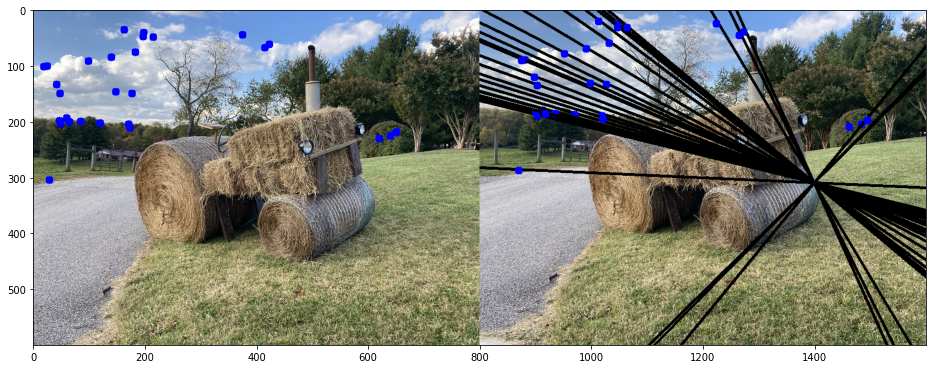

In [ ]:
stereoMatchingAndDisplaynorans('/content/tractor1.png', '/content/tractor2.png')

## **After Ransac**

In [ ]:
##############################
# TO DO: Write code to test your RANSAC implementation (your function findFundamentalMatrixUsingRansac)
# 

def stereoMatchingAndDisplay(img1file, img2file):
  '''Extract keypoints from a stereo image pair, find corresponding points, 
      compute the fundamental matrix (assuming no outliers), 
      and display the results with sample epipolar lines. 
   Input:
    img1file: name of file containing image 1
    img2file: name of file containing image 2
   Output:
    No return value; the output is a visual display  
  '''
  img1 = cv2.imread(img1file)
  img2 = cv2.imread(img2file)
  pts1, pts2, matches1to2, kp1, kp2 = genSIFTMatchPairs(img1, img2, 30)
  #print(pts1)
  #print(pts2)
  
  Fmat = findFundamentalMatrixUsingRansac(pts1, pts2, 800)

  
  
  #Fmat = findFundamentalMatrixUsingRansac(pts1, pts2, 800)
  #e1tmp, e2tmp = findEpipoles(Fmat)

  # Print F and the epipoles
  print('Fmat =\n', Fmat)
  print('\n')
  #print('normalized epipole #1:', e1tmp/e1tmp[2])
  #print('normalized epipole #2:', e2tmp/e2tmp[2])
  displayEpipolarLines(pts1, pts2, Fmat, img1, img2)




Fmat =
 [[ 2.52720979e-06  5.19885967e-05 -4.53572564e-02]
 [-5.07514383e-05 -3.21236785e-05 -1.06372612e-01]
 [ 4.04901452e-02  1.09055036e-01  1.00000000e+00]]




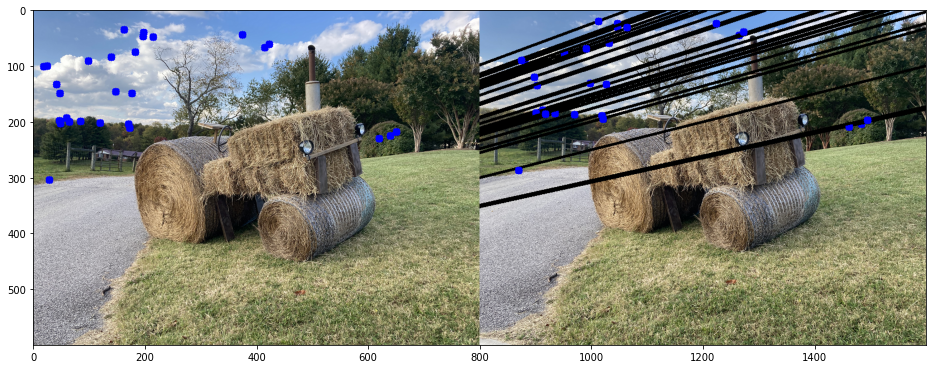

In [ ]:
stereoMatchingAndDisplay('/content/tractor1.png', '/content/tractor2.png')

## **Reasons RANSAC gives better result**

RANSAC gives better result as it considerably removes outliers(points above the threshold) while calculating the fundamental matrix and makes use of only the inliers. If for example 50 points are chosen a non ransac method uses all 50 points while RANSAC makes use of only inliers say 25 points out of 50, as the fundamental matrix is calculated only with inliers gives a good match.

---
# Creating a PDF version of your current notebook

In [ ]:
#The following two installation steps are needed to generate a PDF version of the notebook
#(These lines are needed within Google Colab, but are not needed within a local version of Jupyter notebook)
!apt-get -qq install texlive texlive-xetex texlive-latex-extra pandoc 
!pip install --quiet pypandoc

Extracting templates from packages: 100%
Preconfiguring packages ...
Selecting previously unselected package fonts-droid-fallback.
(Reading database ... 123942 files and directories currently installed.)
Preparing to unpack .../00-fonts-droid-fallback_1%3a6.0.1r16-1.1_all.deb ...
Unpacking fonts-droid-fallback (1:6.0.1r16-1.1) ...
Selecting previously unselected package fonts-lato.
Preparing to unpack .../01-fonts-lato_2.0-2_all.deb ...
Unpacking fonts-lato (2.0-2) ...
Selecting previously unselected package poppler-data.
Preparing to unpack .../02-poppler-data_0.4.8-2_all.deb ...
Unpacking poppler-data (0.4.8-2) ...
Selecting previously unselected package tex-common.
Preparing to unpack .../03-tex-common_6.09_all.deb ...
Unpacking tex-common (6.09) ...
Selecting previously unselected package fonts-lmodern.
Preparing to unpack .../04-fonts-lmodern_2.004.5-3_all.deb ...
Unpacking fonts-lmodern (2.004.5-3) ...
Selecting previously unselected package fonts-noto-mono.
Preparing to unpack .

In [ ]:
# TO DO: Provide the full path to your Jupyter notebook file
!jupyter nbconvert --to PDF "/content/drive/MyDrive/Colab Notebooks/Homework4_bennyantony.ipynb"

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/Homework4_bennyantony.ipynb to PDF
[NbConvertApp] Support files will be in Homework4_bennyantony_files/
[NbConvertApp] Making directory ./Homework4_bennyantony_files
[NbConvertApp] Making directory ./Homework4_bennyantony_files
[NbConvertApp] Making directory ./Homework4_bennyantony_files
[NbConvertApp] Making directory ./Homework4_bennyantony_files
[NbConvertApp] Making directory ./Homework4_bennyantony_files
[NbConvertApp] Making directory ./Homework4_bennyantony_files
[NbConvertApp] Making directory ./Homework4_bennyantony_files
[NbConvertApp] Making directory ./Homework4_bennyantony_files
[NbConvertApp] Writing 98244 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', './notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', './notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertAp